# A Look at the Dataset

Before starting in earnest with Machine Learning it is worth having a look at the dataset.

This will give us a chance to assess our hopes of survival: after all, we have simulated a lot of configurations and we can get an idea of how many of them are working. In general, it is important to get a feeling of how our target system (i.e. the zombie horde) works, so that we will be better able to shape ideas and spot mistakes.

## Loading the Data

Let's start from the basics, i.e. reading the data from the `za_data.csv` file. For this task we will rely [on the pandas module](), which provides efficient and convenient functions to work with large datasets. We will use [the matplotlib module]() for drawing charts.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
# Load data
data_fname = os.path.join('data', 'za_data.csv')
data = pd.read_csv(data_fname)
data.head()

,edge_ratio,inf_prob,act_rate,rec_rate,ds_rate,di_rate,dr_rate,time,s_num,i_num,r_num,num
0,0.001,0.3,1,0.0,0.0,0.03,0.0,7,499,1,0,500
1,0.001,0.3,1,0.0,0.0,0.03,0.0,7,491,9,0,500
2,0.001,0.3,1,0.0,0.0,0.03,0.0,7,494,6,0,500
3,0.001,0.3,1,0.0,0.0,0.03,0.0,7,491,8,0,499
4,0.001,0.3,1,0.0,0.0,0.03,0.0,7,499,1,0,500


The columns of the pandas DataFrame (mosly) correspond to input and outputs of the simulator.

Let's show some basic statistics for each of them:

In [5]:
data.describe()

,edge_ratio,inf_prob,act_rate,rec_rate,ds_rate,di_rate,dr_rate,time,s_num,i_num,r_num,num
count,48600.000000,48600.000000,48600.000000,48600.000000,48600.000000,48600.00000,48600.000000,48600.0,48600.000000,48600.000000,48600.000000,48600.000000
mean,0.003000,0.500000,2.000000,0.056250,0.025000,0.13000,0.025000,7.0,277.874774,130.481337,8.557490,416.913601
std,0.001414,0.163301,0.816505,0.036976,0.020413,0.08165,0.020413,0.0,174.706446,144.124146,15.272002,58.180121
min,0.001000,0.300000,1.000000,0.000000,0.000000,0.03000,0.000000,7.0,0.000000,0.000000,0.000000,204.000000
25%,0.002000,0.300000,1.000000,0.037500,0.000000,0.03000,0.000000,7.0,95.000000,0.000000,0.000000,369.000000
50%,0.003000,0.500000,2.000000,0.062500,0.025000,0.13000,0.025000,7.0,347.000000,56.000000,1.000000,421.000000
75%,0.004000,0.700000,3.000000,0.081250,0.050000,0.23000,0.050000,7.0,423.000000,268.000000,10.000000,476.000000
max,0.005000,0.700000,3.000000,0.100000,0.050000,0.23000,0.050000,7.0,500.000000,486.000000,115.000000,500.000000


It is useful at this point to summarize some pieces of information that are important for our setup, such as the actual names of the simulator input/output, their numbers, their default values, and the population size:

In [6]:
# Some meta-information
sim_in = ['edge_ratio', 'inf_prob', 'act_rate', 'rec_rate', 'ds_rate', 'di_rate']
sim_out = ['i_num', 'survivors']
n_in = len(sim_in)
n_out = len(sim_out)
in_defaults = [0.004, 0.7, 3, 0, 0.05, 0.00]
pop_size = 500

If we group the data by input value, we can verify that the dataset has indeed been obtained via a factorial design:

In [7]:
data.groupby(sim_in)[['num']].count()

num
edge_ratio inf_prob act_rate rec_rate ds_rate di_rate     
0.001      0.3      1        0.000    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.050    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.075    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.100    0.000   0.03      30
                                              0.13      30
                                              0.23      30
...                                                    ...
0.005      0.7      3        0.000    0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.050    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.075    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30
                             0.100    0.000   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.025   0.03      30
                                              0.13      30
                                              0.23      30
                                      0.050   0.03      30
                                              0.13      30
                                              0.23      30

[1620 rows x 1 columns]

## Estimating our Odds (Roughly)

We can then have a look at the distribution of some of our Key Performance Indicators, such as the number of survivors and zombies. This will give us an idea of how many times the input configurations that we tested led to satisfactory results: it is a rough way to estimate how challenging it is to come up with a solution for our problem. 

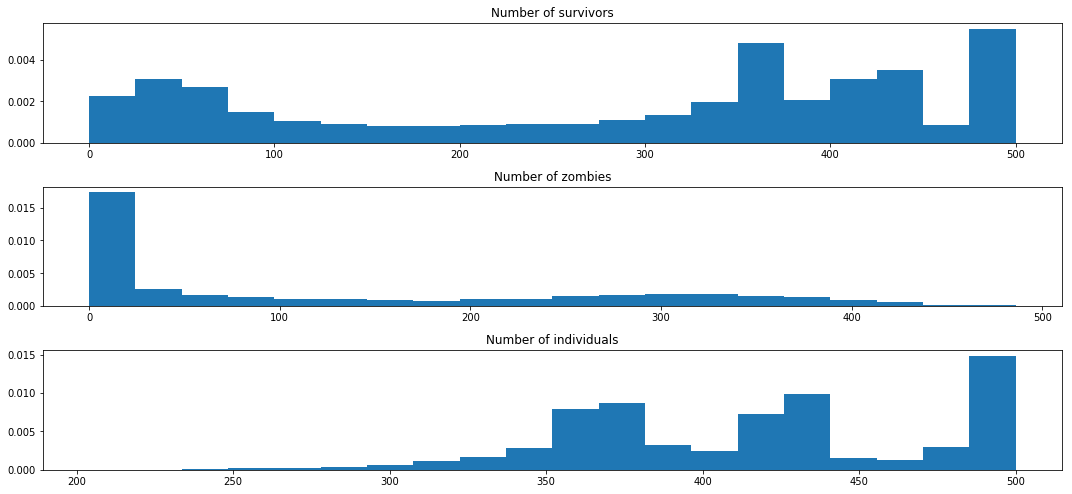

In [8]:
# Compute a new column (number of survivors)
data['survivors'] = data['s_num'] + data['r_num']

# Plot a a few distribution
nbins = 20
plt.figure(figsize=(15, 9))
# --- Susceptibles
plt.subplot(411)
plt.title('Number of survivors')
plt.hist(data.survivors, bins=nbins, density=True)
# --- Infected
plt.subplot(412)
plt.title('Number of zombies')
plt.hist(data.i_num, bins=nbins, density=True)
# --- Total
plt.subplot(413)
plt.title('Number of individuals')
plt.hist(data.num, bins=nbins, density=True)
plt.tight_layout()

Surprisingly, things don't look too bad: while veritable pandemics and massive dieoffs are a concrete possibility, in many cases the number of survivors is very large.

We have a fighting chance!

Just don't get too excited: so far, we are **assuming to have complete control on the system input**. In practice, of course, we will control the inputs only indirectly (through our preparation measures) and **there will be constraints** (e.g. the limited budget).

Next, let's have a look at the effect of each individual parameters on the number of survivors, using 2d histograms:

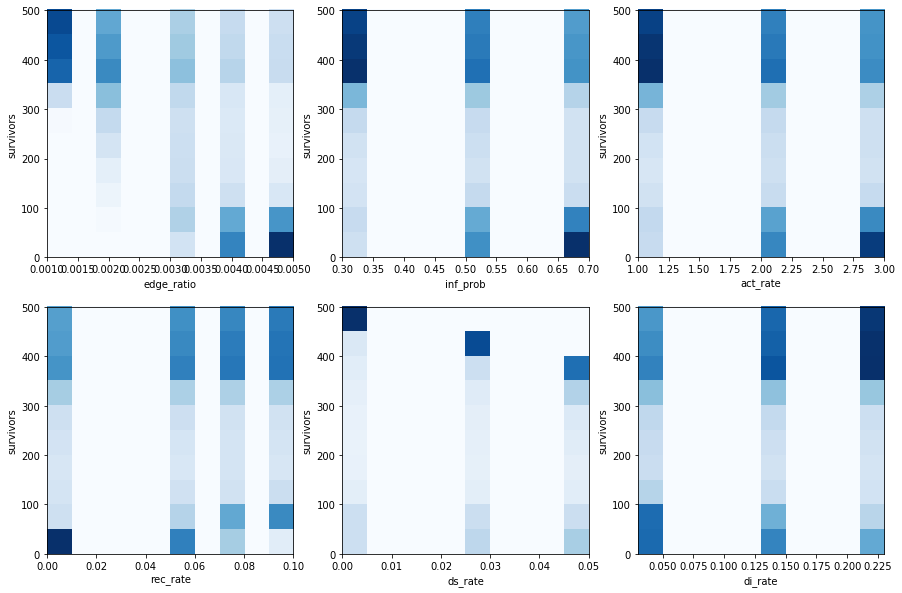

In [9]:
# Effect of the input parameters in the number of survivorss
nrows = int(np.ceil(n_in / 3))
plt.figure(figsize=(15, 5*nrows))
for i, in_name in enumerate(sim_in):
    plt.subplot(nrows, 3, i+1)
    plt.hist2d(data[in_name], data['survivors'], cmap='Blues')
    plt.xlabel(in_name)
    plt.ylabel('survivors')

Some parameters have a rather clear impact (e.g. `edge.ratio`, `inf.prob`, `act.rate` and in particular `ds.rate`). However, no input paramter by itself is enough to give a very good prediction.

And now the number of zombies:

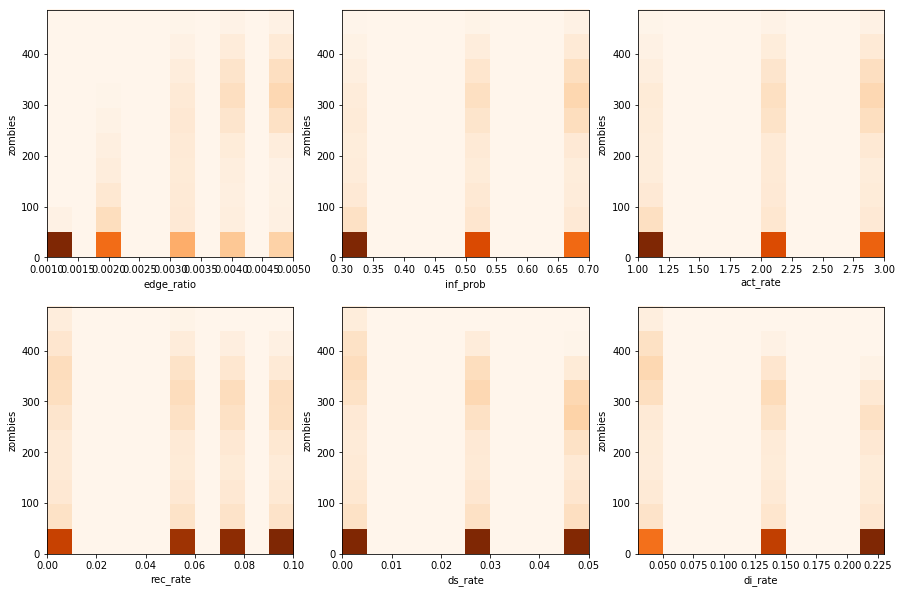

In [12]:
# Effect of the input parameters in the number of zombies
nrows = int(np.ceil(n_in / 3))
plt.figure(figsize=(15, 5*nrows))
for i, in_name in enumerate(sim_in):
    plt.subplot(nrows, 3, i+1)
    plt.hist2d(data[in_name], data['i_num'], cmap='Oranges')
    plt.xlabel(in_name)
    plt.ylabel('zombies')

The number of zombies is low in most cases, but it can grow pretty large. Here `edge.ratio` has the most dramatic impact: a very low value is by itself enough to ensure a rather small number of brain eaters. Unfortunately, avoiding encounters in a working place and tight confines is not an easy thing to do in practice, so reducing `edge.ratio` that much will be a challenge.

## Preparing the Training Dataset

We can now split our data into a training, validation, and test set:

In [14]:
# Row indices
snum = len(data)
sidx = np.arange(snum, dtype=int)

# Shuffle
np.random.seed(42)
np.random.shuffle(sidx)

# Define the separators
sep1 = int(snum * 2/3)
sep2 = int(snum * 5/6)
sidx_tr = sidx[:sep1]
sidx_vl = sidx[sep1:sep2]
sidx_ts = sidx[sep2:]

# Split the dataset
data_tr = data.iloc[sidx_tr]
data_vl = data.iloc[sidx_vl]
data_ts = data.iloc[sidx_ts]

We proceed to standardize the inputs and normalize the output, as it will come in handy when learning ML models: 

In [21]:
# Standardize inputs
means_in = data_tr[sim_in].mean(axis=0)
stds_in = data_tr[sim_in].std(axis=0)
data_tr[sim_in] = (data_tr[sim_in] - means_in) / stds_in
data_vl[sim_in] = (data_vl[sim_in] - means_in) / stds_in
data_ts[sim_in] = (data_ts[sim_in] - means_in) / stds_in

# Standardize output
data_tr[sim_out] /= pop_size
data_vl[sim_out] /= pop_size
data_ts[sim_out] /= pop_size

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Then, let's store everything in a more convenient format:

In [18]:
# Store into an HDF5 archive
hdf_fname = os.path.join('shared', 'za_processed.h5')
with pd.HDFStore(hdf_fname, 'w') as store:
    store['data'] = data
    store['data_tr'] = data_tr
    store['data_vl'] = data_vl
    store['data_ts'] = data_ts
    store['means_in'] = means_in
    store['stds_in'] = stds_in
    store['sim_in'] = pd.Series(sim_in)
    store['sim_out'] = pd.Series(sim_out)
    store['in_defaults'] = pd.Series(index=sim_in, data=in_defaults)
    store['meta'] = pd.Series(index=['pop_size'], data=[pop_size])